# **Prepare datasets**

Kami memakai dataset dari link ini https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view. Di dalamnya terdapat file train_preporcess.tsv.txt yang kami simpan di folder contentplatinum

Setelah kami download, file tersebut kami import dengan pandas kedalam notebook ini untuk diolah.

In [1]:
import pandas as pd


df = pd.read_table('contentplatinum/train_preprocess.tsv.txt', header=None)
df.columns = ['text', 'label']

In [2]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
df.shape

(11000, 2)

In [4]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 12000 label data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



# **Text Normalization/Cleansing**

Lalu kami lakukan cleansing sebagai berikut

In [5]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [6]:
df['text_clean'] = df.text.apply(cleansing)

In [7]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


Sortir data dan label berdasarkan sentimen

In [8]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [9]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# **Feature Extraction**

Setelah itu kami melakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow. 

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [10]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizerplatinumLSTM.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizerplatinumLSTM.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequencesplatinumLSTM.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequencesplatinumLSTM.pickle has created!")

tokenizerplatinumLSTM.pickle has created!
x_pad_sequencesplatinumLSTM.pickle has created!


In [11]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labelsplatinumLSTM.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labelsplatinumLSTM.pickle has created!")

y_labelsplatinumLSTM.pickle has created!


In [12]:
Y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [14]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequencesplatinumLSTM.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labelsplatinumLSTM.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [15]:
X.shape


(11000, 96)

In [16]:
Y.shape

(11000, 3)

# **Training**

Jalankan training dengan metode LSTM. Arsitektur LSTM ini dibangun menggunakan framework Tensorflow.

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten
from keras import backend as K

In [18]:
import sys

# Check if a virtual environment is active
is_virtualenv = hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix)

if is_virtualenv:
    print("A virtual environment is active.")
else:
    print("No virtual environment is active.")


No virtual environment is active.


In [19]:
!which python


/Applications/anaconda3/bin/python


In [20]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur LSTM yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100. 
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [21]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)    
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 42s 46ms/step - loss: 0.4588 - accuracy: 0.8184 - val_loss: 0.3542 - val_accuracy: 0.8714
Epoch 2/10
880/880 [==============================] - 45s 51ms/step - loss: 0.1988 - accuracy: 0.9267 - val_loss: 0.3328 - val_accuracy: 0.8718
Epoch 2: early stopping


# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [22]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 10ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       685
           1       0.83      0.81      0.82       233
           2       0.91      0.90      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.87      0.87      0.87      2200



Hasilnya nilai F1 Score ada pada angka 0.83 untuk Negative, 0.82 untuk Neutral, dan 0.91 untuk Positive. Hasil ini bisa dikatakan sudah cukup bagus untuk sebuah model, khususnya pada sentimen positif.

## Cross Validation

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

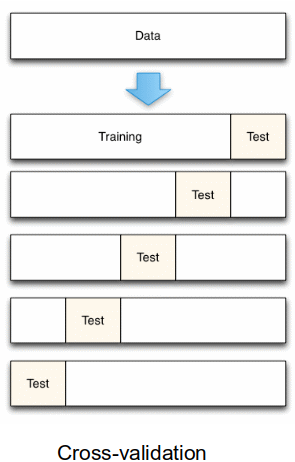

In [23]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3,activation='softmax'))
    #sgd = optimizers.Adam(learning_rate= 0.0001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 39s 43ms/step - loss: 0.4710 - accuracy: 0.8073 - val_loss: 0.3612 - val_accuracy: 0.8759
Epoch 2/10
880/880 [==============================] - 38s 43ms/step - loss: 0.2219 - accuracy: 0.9178 - val_loss: 0.3160 - val_accuracy: 0.8836
Epoch 2: early stopping
69/69 [==============================] - 1s 11ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       685
           1       0.89      0.76      0.82       233
           2       0.89      0.94      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.88      0.84      0.86      2200
weighted avg       0.88      0.88      0.88      2200

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 39s 43ms/step - loss: 0.4736 - accuracy: 0.8148 - val_loss: 0.3488 - val_accuracy: 0.8686
Epoch 2/10
880/880 [==============================] - 38s 43ms/step - loss: 0.2274 - accuracy: 0.9187 - val_loss: 0.3381 - val_accuracy: 0.8764
Epoch 2: early stopping
69/69 [==============================] - 1s 11ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       685
           1       0.85      0.79      0.82       233
           2       0.89      0.94      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.84      0.85      2200
weighted avg       0.88      0.88      0.88      2200

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 39s 43ms/step - loss: 0.4831 - accuracy: 0.8037 - val_loss: 0.3505 - val_accuracy: 0.8682
Epoch 2/10
880/880 [==============================] - 38s 43ms/step - loss: 0.2299 - accuracy: 0.9143 - val_loss: 0.3283 - val_accuracy: 0.8836
Epoch 2: early stopping
69/69 [==============================] - 1s 11ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       685
           1       0.87      0.78      0.82       233
           2       0.91      0.92      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.85      0.86      2200
weighted avg       0.88      0.88      0.88      2200

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 39s 44ms/step - loss: 0.4630 - accuracy: 0.8109 - val_loss: 0.3546 - val_accuracy: 0.8677
Epoch 2/10
880/880 [==============================] - 38s 43ms/step - loss: 0.2218 - accuracy: 0.9178 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 2: early stopping
69/69 [==============================] - 1s 10ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       685
           1       0.81      0.84      0.82       233
           2       0.91      0.92      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.86      0.86      2200
weighted avg       0.88      0.88      0.88      2200

Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


880/880 [==============================] - 39s 43ms/step - loss: 0.4726 - accuracy: 0.8059 - val_loss: 0.3444 - val_accuracy: 0.8732
Epoch 2/10
880/880 [==============================] - 38s 44ms/step - loss: 0.2228 - accuracy: 0.9193 - val_loss: 0.3295 - val_accuracy: 0.8800
Epoch 2: early stopping
69/69 [==============================] - 1s 11ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       685
           1       0.78      0.85      0.81       233
           2       0.92      0.91      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.86      0.86      2200
weighted avg       0.88      0.88      0.88      2200




Rata-rata Accuracy:  0.8812727272727272


Hasilnya nilai rata-rata accuracy pada angka 0.88. Ini menunjukkan model kita cukup stabil pada angka 0.88.

## Visualization

Mekanisme evaluasi selanjutnya menggunakan "Visualization", yaitu mengecek performa training dari arah visualisasinya. Acuan apakah visualisasi bagus atau tidak "Good Fit", sebagai berikut:

**Overfitting**

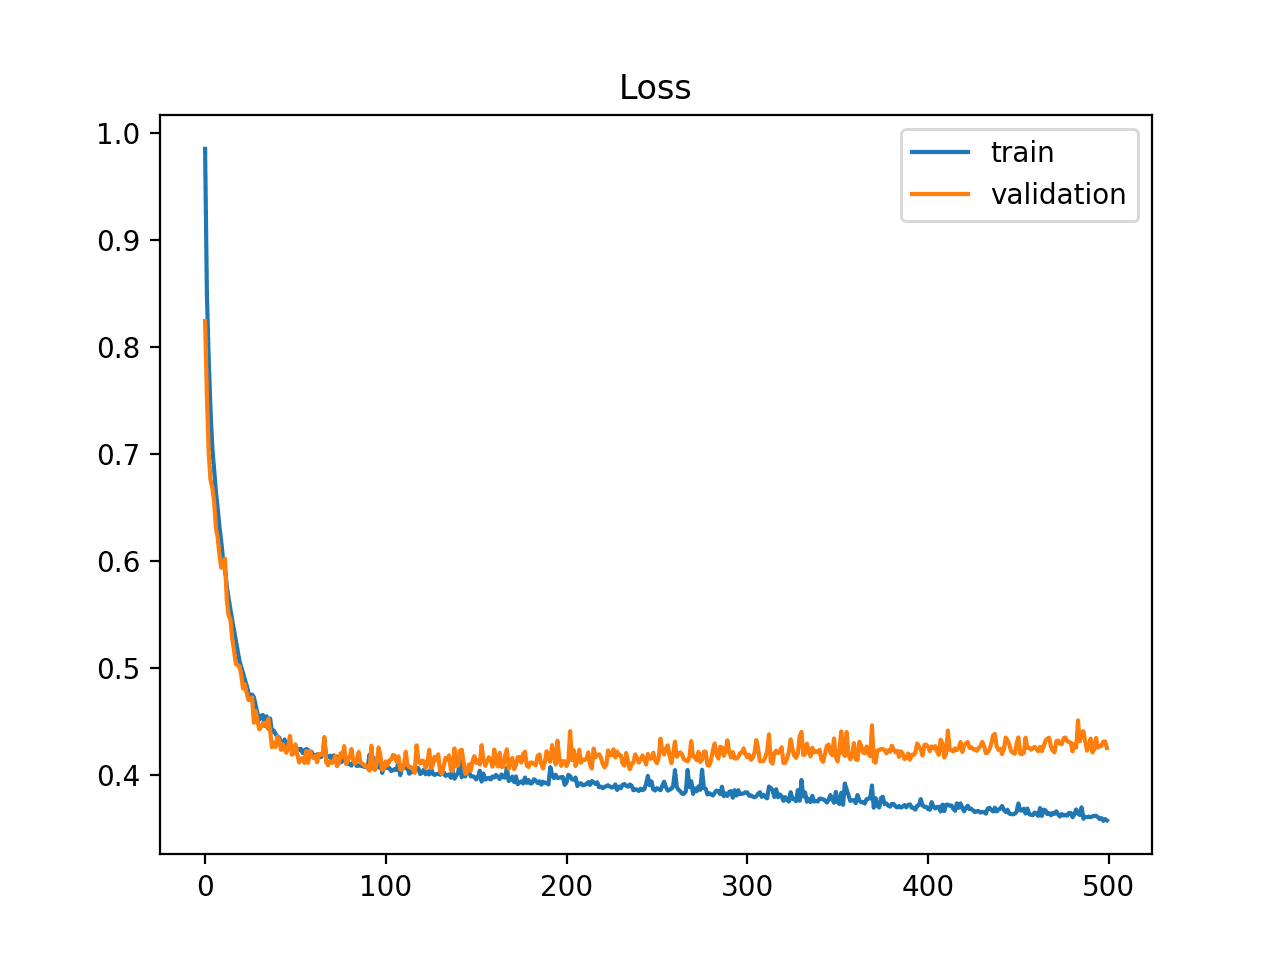

**Underfitting**
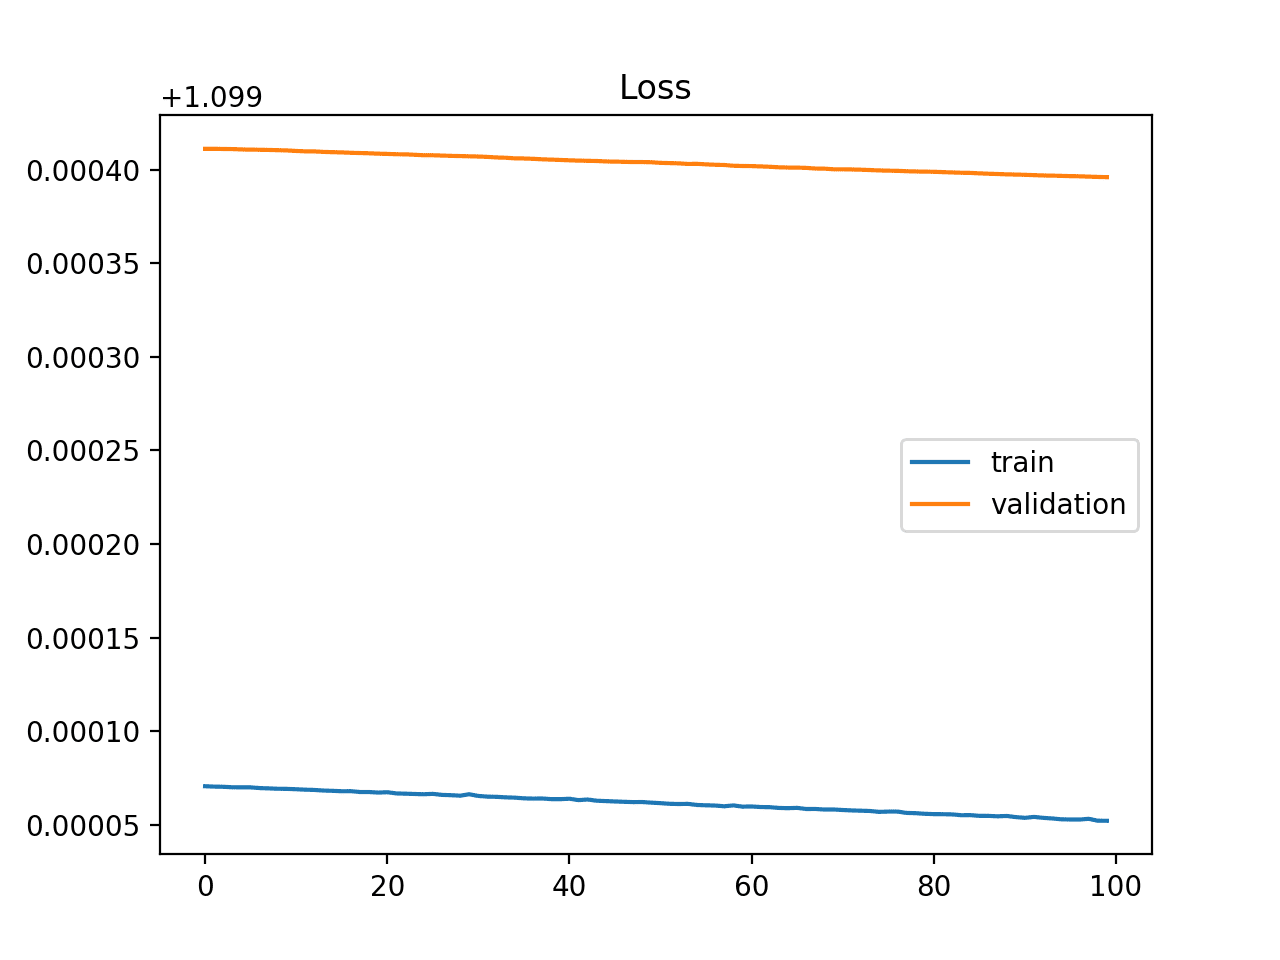

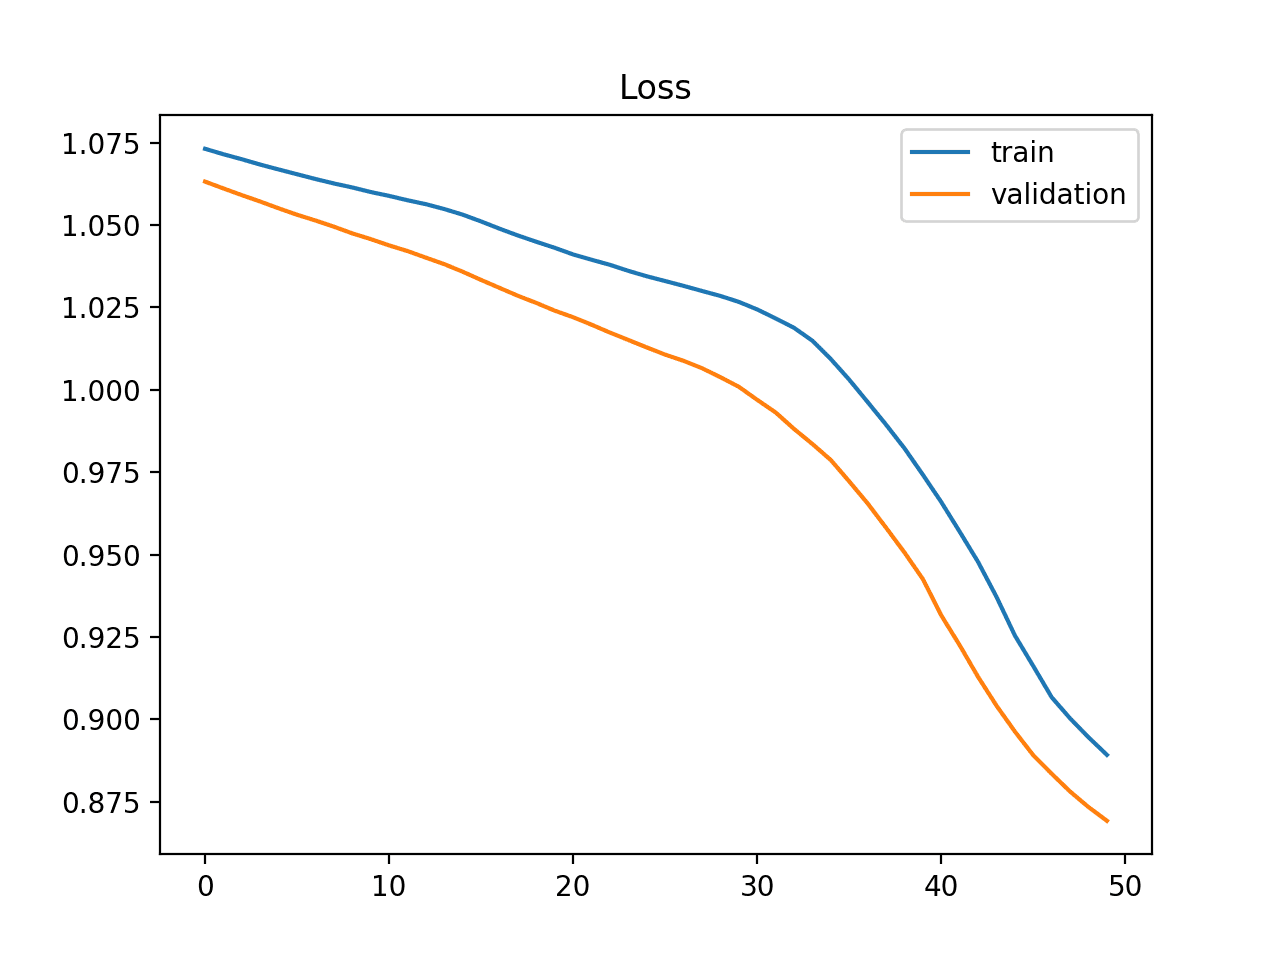

**Good Fit**

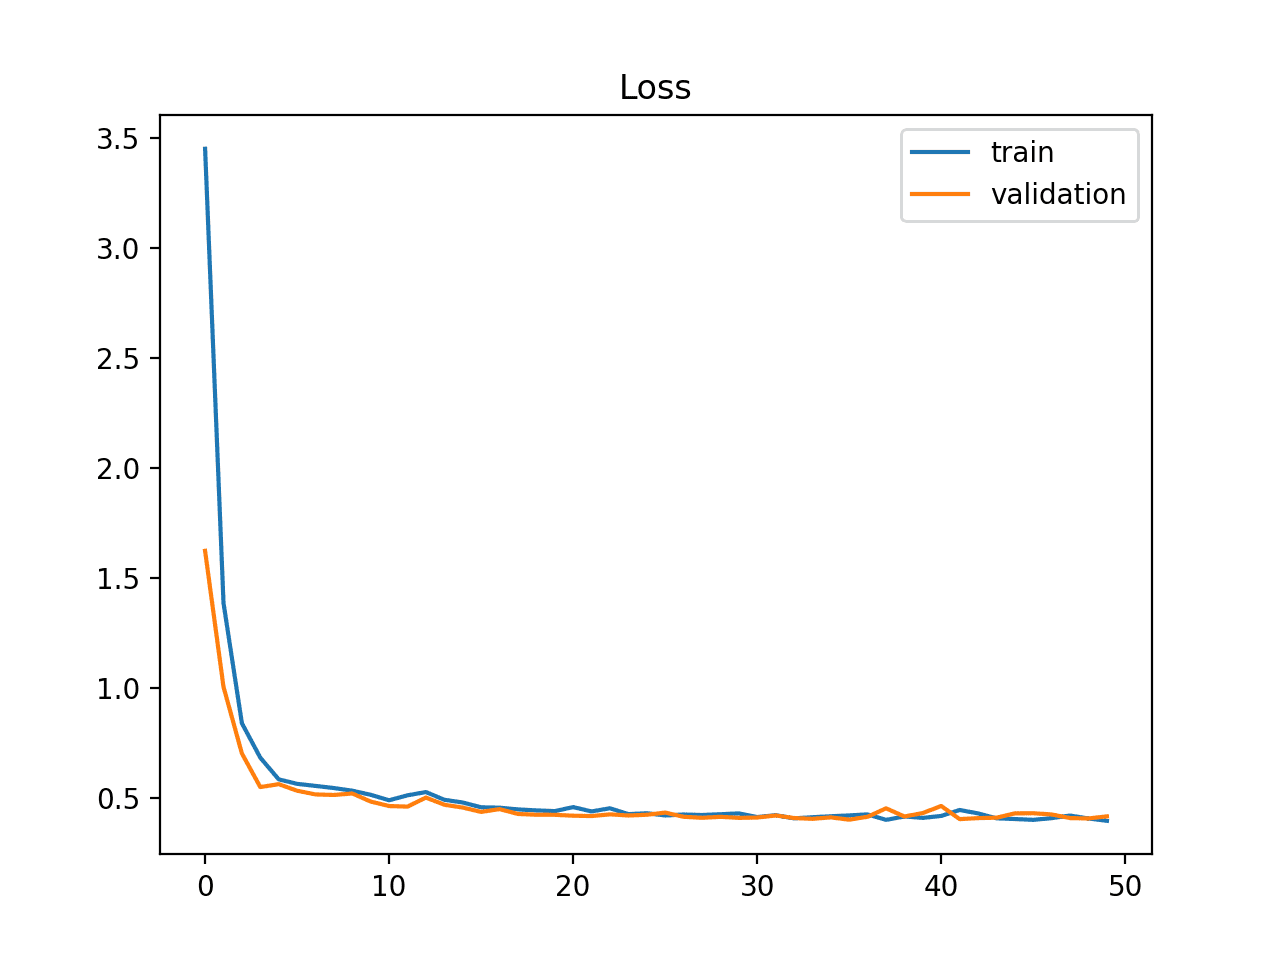

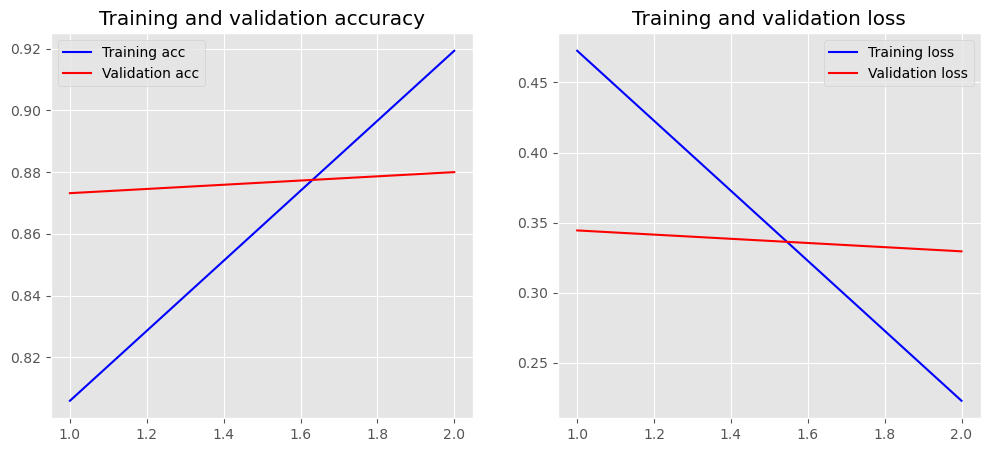

In [24]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Underfitting. Disinyalir karena:


*   Data training terlalu sedikit
*   Proses training berhenti terlalu cepat. Mungkin saja penerapan EarlyStopping untuk kasus kita tidak terlalu tepat
*   Dibutuhkan lebih banyak tuning parameter



In [25]:
model.save('modelplatinumLSTM.h5')
print("ModelplatinumLSTM has created!")

ModelplatinumLSTM has created!


# Predict

In [26]:
import re 
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('modelplatinumLSTM.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 279ms/step
Text:   rasa syukur  cukup  
Sentiment:  positive
